In [ ]:
def load_fer2013(path='fer2013.csv'):
    import pandas as pd
    fer_data = pd.read_csv('fer2013.csv')
    fer_data['emotion_type'] = fer_data['emotion']
    fer_data = fer_data.replace(0, 'Angry')
    fer_data = fer_data.replace(1, 'Disgust')
    fer_data = fer_data.replace(2, 'Fear')
    fer_data = fer_data.replace(3, 'Happy')
    fer_data = fer_data.replace(4, 'Sad')
    fer_data = fer_data.replace(5, 'Surprise')
    fer_data = fer_data.replace(6, 'Neutral')
    fer_data = fer_data.drop('emotion', axis = 1)
    train_data = fer_data[fer_data['Usage']=='Training'].reset_index(drop=True)
    publictest_data = fer_data[fer_data['Usage']=='PublicTest'].reset_index(drop=True)
    privatetest_data = fer_data[fer_data['Usage']=='PrivateTest'].reset_index(drop=True)
    
    return train_data, publictest_data, privatetest_data

train_data, publictest_data, privatetest_data = load_fer2013(path='fer2013.csv')

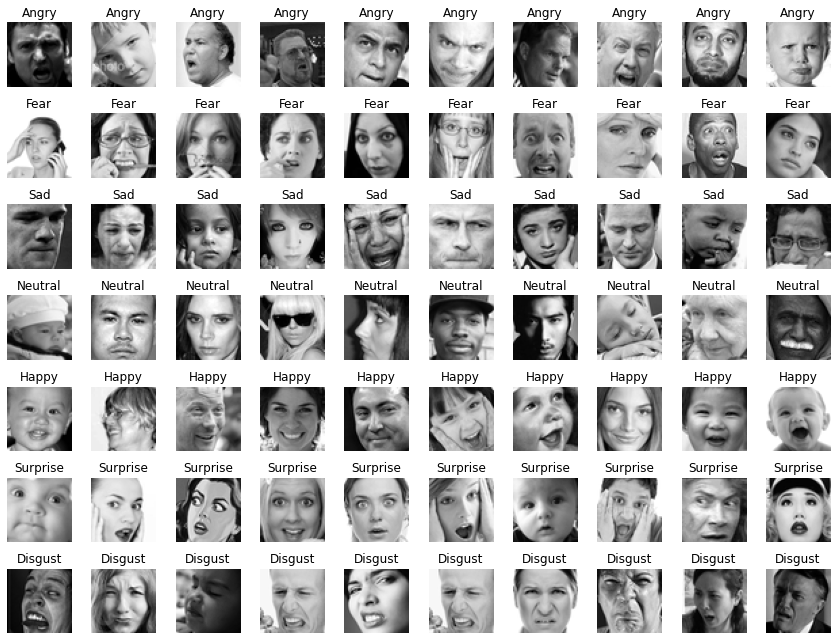

In [ ]:
def plot_faces(data, images_per_row=10, size = 48):
    import matplotlib.pyplot as plt
    import numpy as np
    # set figure size
    plt.figure(figsize=(12,9))
    n_rows = len(data['emotion_type'].unique())
    
    loc = 0
    for category in data['emotion_type'].unique():
        # sample K images for each category
        images = data[data['emotion_type']==category].sample(images_per_row)
        
        for i in range(images_per_row):
            some_pixel = np.array(images.iloc[i]['pixels'].split()).astype('float32') # select one image sample
            some_image = some_pixel.reshape(size, size) # reshape from rank-1 tensor (2304,) to rank-2 tensor (48,48) 
            
            # put image in subplots
            loc += 1
            ax = plt.subplot(n_rows, images_per_row, loc)
            
            ax.imshow(some_image, cmap='gray')
            ax.axis("off")
            ax.set_title(images.iloc[i]['emotion_type'])
        plt.tight_layout()
    plt.axis("off")

plot_faces(train_data, images_per_row=10, size = 48)

In [ ]:
inhouse_train_data =train_data.sample(frac=0.8,random_state=42) 
inhouse_val_data=train_data.drop(inhouse_train_data.index)

# reset the index
inhouse_train_data = inhouse_train_data.reset_index(drop=True)
inhouse_val_data = inhouse_val_data.reset_index(drop=True)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

#### (1) processing in-house training dataset
inhouse_train_features=inhouse_train_data.pixels.str.split(expand=True)
inhouse_train_labels = encoder.fit_transform(inhouse_train_data['emotion_type'])

#### (2) processing in-house validation dataset
inhouse_valid_features=inhouse_val_data.pixels.str.split(expand=True)
inhouse_valid_labels = encoder.fit_transform(inhouse_val_data['emotion_type'])

#### (3) processing public-test dataset
publictest_features=publictest_data.pixels.str.split(expand=True)
publictest_labels = encoder.fit_transform(publictest_data['emotion_type'])

#### (4) processing private-test dataset
privatetest_features=privatetest_data.pixels.str.split(expand=True)
privatetest_labels = encoder.fit_transform(privatetest_data['emotion_type'])
import numpy as np
np.save("inhouse_train_features", inhouse_train_features.to_numpy())
np.save("inhouse_train_labels", inhouse_train_labels)
np.save("inhouse_valid_features", inhouse_valid_features.to_numpy())
np.save("inhouse_valid_labels", inhouse_valid_labels)
np.save("privatetest_features", privatetest_features.to_numpy())
np.save("privatetest_labels", privatetest_labels)
np.save("publictest_features", publictest_features.to_numpy())
np.save("publictest_labels", publictest_labels)

In [ ]:
import numpy as np

inhouse_train_features = np.load("inhouse_train_features.npy", allow_pickle=True)
inhouse_train_labels = np.load("inhouse_train_labels.npy", allow_pickle=True)
inhouse_valid_features = np.load("inhouse_valid_features.npy", allow_pickle=True)
inhouse_valid_labels = np.load("inhouse_valid_labels.npy", allow_pickle=True)
publictest_labels = np.load("publictest_labels.npy", allow_pickle=True)
publictest_features = np.load("publictest_features.npy", allow_pickle=True)
privatetest_features = np.load("privatetest_features.npy", allow_pickle=True)
privatetest_labels = np.load("privatetest_labels.npy", allow_pickle=True)

from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler() ## define the transformer
train_features_norm = scaler.fit_transform(inhouse_train_features)
valid_features_norm = scaler.transform(inhouse_valid_features)
publictest_data_norm = scaler.transform(publictest_features)
privatetest_data_norm = scaler.transform(privatetest_features)


y_train = np.array(inhouse_train_labels).reshape((-1, ))
y_publictest = np.array(publictest_labels).reshape((-1, ))
y_privatetest = np.array(privatetest_labels).reshape((-1, ))

import tensorflow as tf
nb_classes = 7
y_train_categorical = tf.keras.utils.to_categorical(inhouse_train_labels, nb_classes)
y_valid_categorical = tf.keras.utils.to_categorical(inhouse_valid_labels, nb_classes)
y_privatetest_categorical = tf.keras.utils.to_categorical(privatetest_labels, nb_classes)
y_publictest_categorical = tf.keras.utils.to_categorical(publictest_labels, nb_classes)

image_dim = int(np.sqrt(train_features_norm.shape[1]))
train_feature_cnn = train_features_norm.reshape((train_features_norm.shape[0], image_dim, image_dim,1))

valid_feature_cnn = valid_features_norm.reshape((valid_features_norm.shape[0], image_dim, image_dim,1))

publictest_data_norm_cnn = publictest_data_norm.reshape((publictest_data_norm.shape[0], image_dim, image_dim,1))

privatetest_data_norm_cnn = privatetest_data_norm.reshape((privatetest_data_norm.shape[0], image_dim, image_dim,1))

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(penalty = 'l2', C = 1, random_state = 0)
logistic_model.fit(train_features_norm, y_train)
log_pred_train = logistic_model.predict(train_features_norm)
log_pred_publictest = logistic_model.predict(publictest_data_norm)
log_pred_privatetest = logistic_model.predict(privatetest_data_norm)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
log_acc_train = accuracy_score(y_train, log_pred_train)
log_prec_train = precision_score(y_train, log_pred_train,pos_label='positive',average='micro')
log_recall_train = recall_score(y_train, log_pred_train,pos_label='positive',average='micro')
log_f1_train = f1_score(y_train, log_pred_train,pos_label='positive',average='micro')

log_acc_publictest = accuracy_score(y_publictest, log_pred_publictest)
log_prec_publictest = precision_score(y_publictest, log_pred_publictest,pos_label='positive',average='micro')
log_recall_publictest = recall_score(y_publictest, log_pred_publictest,pos_label='positive',average='micro')
log_f1_publictest = f1_score(y_publictest, log_pred_publictest,pos_label='positive',average='micro')

log_acc_privatetest = accuracy_score(y_privatetest, log_pred_privatetest)
log_prec_privatetest = precision_score(y_privatetest, log_pred_privatetest,pos_label='positive',average='micro')
log_recall_privatetest = recall_score(y_privatetest, log_pred_privatetest,pos_label='positive',average='micro')
log_f1_privatetest = f1_score(y_privatetest, log_pred_privatetest,pos_label='positive',average='micro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16)
random_forest_model.fit(train_features_norm, y_train)
rf_pred=random_forest_model.predict(train_features_norm)
rf_pred_publictest = random_forest_model.predict(publictest_data_norm)
rf_pred_privatetest = random_forest_model.predict(privatetest_data_norm)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
rf_acc_train = accuracy_score(y_train, rf_pred)
rf_prec_train = precision_score(y_train, rf_pred,pos_label='positive',average='micro')
rf_recall_train = recall_score(y_train, rf_pred,pos_label='positive',average='micro')
rf_f1_train = f1_score(y_train, rf_pred,pos_label='positive',average='micro')

rf_acc_publictest = accuracy_score(y_publictest, rf_pred_publictest)
rf_prec_publictest = precision_score(y_publictest, rf_pred_publictest,pos_label='positive',average='micro')
rf_recall_publictest = recall_score(y_publictest, rf_pred_publictest,pos_label='positive',average='micro')
rf_f1_publictest = f1_score(y_publictest, rf_pred_publictest,pos_label='positive',average='micro')

rf_acc_privatetest = accuracy_score(y_privatetest, rf_pred_privatetest)
rf_prec_privatetest = precision_score(y_privatetest, rf_pred_privatetest,pos_label='positive',average='micro')
rf_recall_privatetest = recall_score(y_privatetest, rf_pred_privatetest,pos_label='positive',average='micro')
rf_f1_privatetest = f1_score(y_privatetest, rf_pred_privatetest,pos_label='positive',average='micro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels

In [ ]:
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import numpy as np
callback = [
        EarlyStopping(monitor='val_loss', patience=20, verbose=True),
        ModelCheckpoint('./best_weights.h5', monitor='val_accuracy', verbose=True, save_best_only=True,
                        save_weights_only=True)]
scaler = StandardScaler()


### define your layers here
nn_model = Sequential()
for i in range(4):
  nn_model.add(Dense(100, activation = 'relu', kernel_initializer='uniform'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(7, activation = 'softmax'))
### define your loss function below
nn_model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=["accuracy", "Precision", "Recall", "AUC"])

nn_model.fit(train_features_norm,y_train_categorical, validation_data=(valid_features_norm,y_valid_categorical), batch_size=64, epochs = 100,callbacks=callback)
nn_pred = nn_model.predict(train_features_norm, batch_size = 10)
nn_pred_test = nn_model.predict(publictest_data_norm, batch_size = 10)

Epoch 1/100
352/359 [============================>.] - ETA: 0s - loss: 1.6963 - accuracy: 0.3272 - precision: 0.5874 - recall: 0.0576 - auc: 0.7211
Epoch 1: val_accuracy improved from -inf to 0.36381, saving model to ./best_weights.h5
359/359 [==============================] - 6s 9ms/step - loss: 1.6960 - accuracy: 0.3274 - precision: 0.5861 - recall: 0.0575 - auc: 0.7215 - val_loss: 1.6248 - val_accuracy: 0.3638 - val_precision: 0.6864 - val_recall: 0.0766 - val_auc: 0.7524
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 1.5931 - accuracy: 0.3803 - precision: 0.6614 - recall: 0.1133 - auc: 0.7648
Epoch 2: val_accuracy improved from 0.36381 to 0.39063, saving model to ./best_weights.h5
359/359 [==============================] - 2s 6ms/step - loss: 1.5931 - accuracy: 0.3803 - precision: 0.6614 - recall: 0.1133 - auc: 0.7648 - val_loss: 1.5749 - val_accuracy: 0.3906 - val_precision: 0.6421 - val_recall: 0.1459 - val_auc: 0.7711
Epoch 3/100
353/359 [================

In [ ]:
nn_eval = nn_model.evaluate(train_features_norm,y_train_categorical, verbose='false')
nn_f1 = (2*nn_eval[2]*nn_eval[3])/(nn_eval[2]+nn_eval[3])
nn_eval_test = nn_model.evaluate(publictest_data_norm, y_publictest_categorical, verbose='false')
nn_f1_test = (2*nn_eval_test[2]*nn_eval_test[3])/(nn_eval_test[2]+nn_eval_test[3])
nn_eval_private = nn_model.evaluate(privatetest_data_norm, y_privatetest_categorical, verbose='false')
nn_f1_private = (2*nn_eval_test[2]*nn_eval_test[3])/(nn_eval_test[2]+nn_eval_test[3])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D
from keras import regularizers
from keras.layers import Flatten,BatchNormalization,Dropout
import tensorflow as tf
 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callback = [
       EarlyStopping(monitor='val_loss', patience=15, verbose=True)]
 
 
 
 
cnn_model = Sequential()
 
cnn_model.add(Conv2D(32, (3,3), input_shape=(image_dim,image_dim,1), padding='same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.5))
 
cnn_model.add(Conv2D(64, (3,3),activation = 'relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.5))
 
cnn_model.add(Conv2D(128, (6,6),activation = 'relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.5))
 
cnn_model.add(Conv2D(512, (3,3),activation = 'relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.2))
 
cnn_model.add(Conv2D(1024, (3,3),activation = 'relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(2048,activation = 'relu'))
cnn_model.add(Dense(512,activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64,activation = 'relu'))
cnn_model.add(Dropout(0.05))
cnn_model.add(Dense(7, activation = 'softmax'))
 
optm = tf.keras.optimizers.Adam(learning_rate=0.001)
 
cnn_model.compile(loss = "categorical_crossentropy", optimizer = optm, metrics = ["accuracy", "Precision", "Recall", "AUC"])
train_history = cnn_model.fit(train_feature_cnn,y_train_categorical, validation_data=(publictest_data_norm_cnn,y_publictest_categorical), batch_size=32, epochs = 120,callbacks = callback)


Epoch 1/120
718/718 [==============================] - 26s 22ms/step - loss: 1.8280 - accuracy: 0.2520 - precision: 0.4479 - recall: 0.0159 - auc: 0.6606 - val_loss: 1.6928 - val_accuracy: 0.2998 - val_precision: 0.5844 - val_recall: 0.1708 - val_auc: 0.7292
Epoch 2/120
718/718 [==============================] - 14s 19ms/step - loss: 1.6197 - accuracy: 0.3479 - precision: 0.6960 - recall: 0.1248 - auc: 0.7504 - val_loss: 1.4724 - val_accuracy: 0.4021 - val_precision: 0.7603 - val_recall: 0.2112 - val_auc: 0.8012
Epoch 3/120
718/718 [==============================] - 14s 19ms/step - loss: 1.5234 - accuracy: 0.3883 - precision: 0.7487 - recall: 0.1671 - auc: 0.7861 - val_loss: 1.5105 - val_accuracy: 0.3979 - val_precision: 0.6280 - val_recall: 0.2836 - val_auc: 0.7990
Epoch 4/120
718/718 [==============================] - 14s 19ms/step - loss: 1.4674 - accuracy: 0.4089 - precision: 0.7714 - recall: 0.1920 - auc: 0.8031 - val_loss: 1.3941 - val_accuracy: 0.4324 - val_precision: 0.7895 - v

In [ ]:
cnn_eval = cnn_model.evaluate(train_feature_cnn,y_train_categorical, verbose='false')
cnn_f1 = (2*cnn_eval[2]*cnn_eval[3])/(cnn_eval[2]+cnn_eval[3])
cnn_eval_test = cnn_model.evaluate(publictest_data_norm_cnn, y_publictest_categorical, verbose='false')
cnn_f1_test = (2*cnn_eval_test[2]*cnn_eval_test[3])/(cnn_eval_test[2]+cnn_eval_test[3])
cnn_eval_private = cnn_model.evaluate(privatetest_data_norm_cnn, y_privatetest_categorical, verbose='false')
cnn_f1_private = (2*cnn_eval_test[2]*cnn_eval_test[3])/(cnn_eval_test[2]+cnn_eval_test[3])

In [ ]:
import pandas as pd
performance_df=pd.DataFrame({'Methods':['Logistic Regression_train','Logistic Regression_publictest','Logistic Regression_privatetest','Random Forest_train','Random Forest_publictest','Random Forest_privatetest','Neural Network_train','Neural Network_publictest','Neural Network_Privatetest','Convolutional Neural Network_train','Convolutional Neural Network_publictest','Convolutional Neural Network_Private_test'],
    'Accuracy':[log_acc_train,log_acc_publictest,log_acc_privatetest,rf_acc_train,rf_acc_publictest,rf_acc_privatetest,nn_eval[1],nn_eval_test[1],nn_eval_private[1],cnn_eval[1],cnn_eval_test[1],cnn_eval_private[1]],
    'Precision':[log_prec_train,log_prec_publictest,log_prec_privatetest,rf_prec_train,rf_prec_publictest,rf_prec_privatetest,nn_eval[2],nn_eval_test[2],nn_eval_private[2],cnn_eval[2],cnn_eval_test[2],cnn_eval_private[2]],
    'Recall':[ log_recall_train,log_recall_publictest,log_recall_privatetest,rf_recall_train,rf_recall_publictest,rf_recall_privatetest,nn_eval[3],nn_eval_test[3],nn_eval_private[3],cnn_eval[3],cnn_eval_test[3],cnn_eval_private[3]],
    'F1-score':[ log_f1_train,log_f1_publictest,log_f1_privatetest,rf_f1_train,rf_f1_publictest,rf_f1_privatetest,nn_f1,nn_f1_test,nn_f1_private,cnn_f1,cnn_f1_test,cnn_f1_private]})
performance_df

,Methods,Accuracy,Precision,Recall,F1-score
0,Logistic Regression_train,0.458658,0.458658,0.458658,0.458658
1,Logistic Regression_publictest,0.354974,0.354974,0.354974,0.354974
2,Logistic Regression_privatetest,0.364726,0.364726,0.364726,0.364726
3,Random Forest_train,0.317238,0.317238,0.317238,0.317238
4,Random Forest_publictest,0.314294,0.314294,0.314294,0.314294
5,Random Forest_privatetest,0.309836,0.309836,0.309836,0.309836
6,Neural Network_train,0.777681,0.879493,0.686071,0.770834
7,Neural Network_publictest,0.431039,0.493379,0.363332,0.418485
8,Neural Network_Privatetest,0.425188,0.494464,0.360825,0.418485
9,Convolutional Neural Network_train,0.791396,0.869626,0.705447,0.778980
